In [123]:
import torch
import numpy as np
import torch.nn as nn
from torch_dataloading import sine_data_generation
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


In [124]:
def reinitialize_parameters(model):
    """
    Reinitialize all parameters of the given model.
    """
    for name, param in model.named_parameters():
        if 'weight' in name:
            nn.init.kaiming_uniform_(param.data, nonlinearity='relu')
        elif 'bias' in name:
            nn.init.constant_(param.data, 0)

#### Ok so here the way this works: the embedder first embeds the sequence, and we take the latent representation to be the final hidden state in the net. Then, we COPY this state over as the first hidden state in the recovery network, and we pass in a sequence of zeros as input - THIS HAS NO EFFECT ON THE GRU as all activations evaluate to zero when applied to zero - this is only here to tell the recovery what the output sequence length should be.

#### The recovery net then tries to reconstruct the original sequence, but BACKWARDs. This is because the most first hidden state is fewer computations away from the last element in the sequence than it is from the first. We accomplish this by simply revering the original string before inserting it into the criteria

#### This is different from how embedding-recovery works in TimeGAN. There, the entire set of last-layer hidden states are used as the embedding - in this sense, they may provide additional information about the temporal dynamics

In [138]:
#starting with unbatched data
class Embed(nn.Module):
    def __init__(self, num_features, hidden_dim):         #Feature size, hidden_dim, n_layers
        super(Embed, self).__init__()
        self.gru = nn.GRU(num_features, hidden_dim, 1, batch_first=True)

    def forward(self, x):
        all_hiddens, last_hidden  = self.gru(x)         #expects input of shape (seq_len, batch, input_size) or (seq_len, num_features)
        #last_hidden = all_hiddens[:,-1,:].unsqueeze(0)            #squeeze to remove the first dimension
        #all_hiddens output shape is (N,L,H) i.e. (batch_size, seq_len, hidden_dim) for batch_first=True
        #we use only the last hidden state
        return last_hidden
    
class Recover(nn.Module):
    def __init__(self, hidden_dim, num_features, seq_len):         #hidden_dim, output_dim, n_layers
        super(Recover, self).__init__()
        self.gru = nn.GRU(hidden_dim, hidden_dim, 1, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_features)
        self.hidden_dim = hidden_dim
        self.seq_len = seq_len

    def forward(self, h_0):       #input shape should be (batch_size, seq_len, hidden_dim) i.e. (N,L,H)
        batch_size = h_0.size(1)
        x = torch.zeros(batch_size, self.seq_len, self.hidden_dim)       #(batch_size, seq_len, hidden_size)
        all_hiddens, _  = self.gru(x, h_0)
        recovered_seq = self.fc(all_hiddens)
        #all_hiddens = all_hiddens#.squeeze(0)
        return recovered_seq

In [151]:
epochs = 1000
no, seq_len, num_features = 200, 24, 1
hidden_dim = 8
    
real_data = np.array(sine_data_generation(no, seq_len, num_features))
real_data = torch.tensor(real_data, dtype=torch.float32)
real_dataloader = DataLoader(real_data, batch_size=32, shuffle=True)        #Batch is first!

embedder = Embed(num_features, hidden_dim)
recovery = Recover(hidden_dim, num_features, seq_len)

embedder_optimizer = torch.optim.Adam(embedder.parameters(), lr=0.001)
recovery_optimizer = torch.optim.Adam(recovery.parameters(), lr=0.001)

criterion = nn.MSELoss()

In [141]:
for epoch in range(epochs):
    for data in real_dataloader:
        embedder_optimizer.zero_grad()
        recovery_optimizer.zero_grad()
        
        embedded = embedder(data)
        recovered = recovery(embedded)
        
        loss = criterion(recovered, torch.flip(data, dims=[1]))
        loss.backward()
        
        embedder_optimizer.step()
        recovery_optimizer.step()
        
    if epoch % 10 == 0:
        print(f'Epoch {epoch}: {loss.item()}')

Epoch 0: 0.6846246123313904
Epoch 10: 0.11160804331302643
Epoch 20: 0.007325584534555674
Epoch 30: 0.00621785968542099
Epoch 40: 0.008901894092559814
Epoch 50: 0.005876478273421526
Epoch 60: 0.0060108257457613945
Epoch 70: 0.006073229014873505
Epoch 80: 0.00624600425362587
Epoch 90: 0.005111949518322945


KeyboardInterrupt: 

Run 1/2
Epoch 0 | Normal Loss: 0.2610048417534147 | Flipped Loss: 0.25019075189317974
Epoch 10 | Normal Loss: 0.027773378949080194 | Flipped Loss: 0.023315254332763807
Epoch 20 | Normal Loss: 0.024325817291225706 | Flipped Loss: 0.02563642045216901
Epoch 30 | Normal Loss: 0.023706397573862757 | Flipped Loss: 0.025231878938419477
Epoch 40 | Normal Loss: 0.02355844421046121 | Flipped Loss: 0.024073518546564237
Epoch 50 | Normal Loss: 0.018216979689896107 | Flipped Loss: 0.013168056761579854
Epoch 60 | Normal Loss: 0.015771540946194103 | Flipped Loss: 0.014587869069405965
Epoch 70 | Normal Loss: 0.014567420285727297 | Flipped Loss: 0.013974623488528388
Epoch 80 | Normal Loss: 0.015098802080111844 | Flipped Loss: 0.01463333038347108
Epoch 90 | Normal Loss: 0.014649812930396624 | Flipped Loss: 0.014319943530218942
Epoch 100 | Normal Loss: 0.015000094925718648 | Flipped Loss: 0.014710332400032453
Epoch 110 | Normal Loss: 0.014665979758969374 | Flipped Loss: 0.01444145744400365
Epoch 120 | No

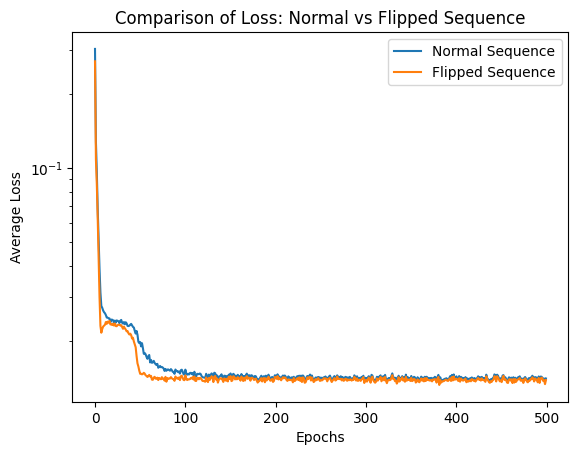

In [152]:
epochs = 500
num_runs = 2

# Arrays to store losses
losses_normal = np.zeros(epochs)
losses_flipped = np.zeros(epochs)

for run in range(num_runs):
    print(f"Run {run + 1}/{num_runs}")
    
    # Resetting or re-initializing your model and optimizers if necessary
    # embedder = ...
    # recovery = ...
    # embedder_optimizer = ...
    # recovery_optimizer = ...
    
    # Track loss for normal and flipped cases
    running_loss_normal = np.zeros(epochs)
    running_loss_flipped = np.zeros(epochs)
    
    for epoch in range(epochs):
        total_loss_normal = 0.0
        total_loss_flipped = 0.0
        
        for data in real_dataloader:
            # Normal sequence training
            embedder_optimizer.zero_grad()
            recovery_optimizer.zero_grad()
            
            embedded = embedder(data)
            recovered = recovery(embedded)
            
            loss_normal = criterion(recovered, data)
            loss_normal.backward()
            
            embedder_optimizer.step()
            recovery_optimizer.step()
            
            total_loss_normal += loss_normal.item()
            
            # Flipped sequence training
            embedder_optimizer.zero_grad()
            recovery_optimizer.zero_grad()
            
            embedded = embedder(data)
            recovered = recovery(embedded)
            
            loss_flipped = criterion(recovered, torch.flip(data, dims=[1]))
            loss_flipped.backward()
            
            embedder_optimizer.step()
            recovery_optimizer.step()
            
            total_loss_flipped += loss_flipped.item()
        
        # Store average loss for this epoch
        running_loss_normal[epoch] += total_loss_normal / len(real_dataloader)
        running_loss_flipped[epoch] += total_loss_flipped / len(real_dataloader)
        
        if epoch % 10 == 0:
            print(f'Epoch {epoch} | Normal Loss: {running_loss_normal[epoch]} | Flipped Loss: {running_loss_flipped[epoch]}')

    # Accumulate losses over the runs
    losses_normal += running_loss_normal
    losses_flipped += running_loss_flipped
    reinitialize_parameters(embedder)
    reinitialize_parameters(recovery)

# Average losses over the runs
losses_normal /= num_runs
losses_flipped /= num_runs

# Plotting the losses
plt.plot(range(epochs), losses_normal, label='Normal Sequence')
plt.plot(range(epochs), losses_flipped, label='Flipped Sequence')
plt.xlabel('Epochs')
plt.ylabel('Average Loss')
plt.title('Comparison of Loss: Normal vs Flipped Sequence')
plt.legend()
plt.yscale('log')
plt.show()

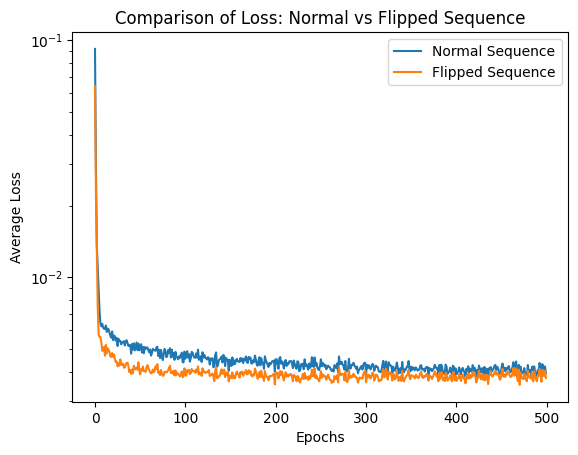

In [137]:
# Plotting the losses
plt.semilogy(range(epochs), losses_normal, label='Normal Sequence')
plt.semilogy(range(epochs), losses_flipped, label='Flipped Sequence')
plt.xlabel('Epochs')
plt.ylabel('Average Loss')
plt.title('Comparison of Loss: Normal vs Flipped Sequence')
plt.legend()
plt.yscale('log')
plt.show()

In [10]:
a = torch.tensor([[[1, 2, 3], [4, 5, 6]],[[10, 20, 30], [40, 50, 60]]], dtype=torch.float32)        #shape (2,2,3)
print(a.shape)
print(a)
print(torch.flip(a, dims=[1]))
#flip dims=[1] means flip the second dimension, of shape, this is what we need for sequence reversal

torch.Size([2, 2, 3])
tensor([[[ 1.,  2.,  3.],
         [ 4.,  5.,  6.]],

        [[10., 20., 30.],
         [40., 50., 60.]]])
tensor([[[ 4.,  5.,  6.],
         [ 1.,  2.,  3.]],

        [[40., 50., 60.],
         [10., 20., 30.]]])


In [9]:
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch_utils as tu
from torch_dataloading import sine_data_generation
import torch

ori_data = sine_data_generation(10, 10, 1)
ori_time, max_seq_len = tu.extract_time(ori_data)
data_tensor = torch.tensor(ori_data, dtype=torch.float32)
time_tensor = torch.tensor(ori_time, dtype=torch.float32)

dataset = TensorDataset(data_tensor, time_tensor)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=0)

for data in dataloader:
    print(data)
    #print(time)
    break

[tensor([[[0.5338],
         [0.5654],
         [0.5967],
         [0.6276],
         [0.6580],
         [0.6878],
         [0.7168],
         [0.7449],
         [0.7721],
         [0.7981]],

        [[0.5224],
         [0.5566],
         [0.5906],
         [0.6241],
         [0.6571],
         [0.6893],
         [0.7206],
         [0.7509],
         [0.7800],
         [0.8078]],

        [[0.5120],
         [0.5438],
         [0.5755],
         [0.6068],
         [0.6377],
         [0.6681],
         [0.6978],
         [0.7266],
         [0.7546],
         [0.7815]],

        [[0.5365],
         [0.5580],
         [0.5793],
         [0.6005],
         [0.6215],
         [0.6423],
         [0.6629],
         [0.6831],
         [0.7030],
         [0.7225]],

        [[0.5388],
         [0.5772],
         [0.6151],
         [0.6523],
         [0.6886],
         [0.7237],
         [0.7576],
         [0.7899],
         [0.8205],
         [0.8491]],

        [[0.5376],
         [0.5678],
 